In [7]:
import gymnasium as gym
import numpy as np
import matplotlib.pylab as plt
from scipy.spatial.distance import cdist
from sklearn.cluster import KMeans


class RBFQAgent():
    def __init__(self, env, num_centers, sigma=0.5, discount_rate=0.95, learning_rate=0.5, c=2.0):
        self.state_size = env.observation_space.n
        self.action_size = env.action_space.n
        self.num_centers = num_centers
        self.sigma = sigma
        self.discount_rate = discount_rate
        self.learning_rate = learning_rate
        self.c = c
        
        # 初始化 RBF 中心
        observations = np.array([env.observation_space.sample() for _ in range(10000)])
        kmeans = KMeans(n_clusters=self.num_centers, random_state=0).fit(observations.reshape(-1, 1))
        self.centers = kmeans.cluster_centers_
        self.weights = np.random.uniform(size=(self.num_centers, self.action_size))
        self.action_count = np.ones(self.action_size)
        self.step = 0

    def _rbf_transform(self, state):
        rbf_features = np.exp(-cdist([[state]], self.centers)**2 / (2 * self.sigma ** 2))
        return rbf_features
        
    def ucb_action_selection(self, state):
        state_rbf = self._rbf_transform(state)
        q_values = np.dot(state_rbf, self.weights)
        total_counts = np.sum(self.action_count)
        ucb_values = np.zeros(self.action_size)
        for action in range(self.action_size):
            if self.action_count[action] > 0:
                bonus = self.c * np.sqrt(np.log(total_counts) / self.action_count[action])
                ucb_values[action] = q_values[0, action] + bonus
            else:
                ucb_values[action] = 1e5  # encourage exploration

        action = np.argmax(ucb_values)
        self.action_count[action] += 1
        return action
    
    def update_weights(self, state, action, reward, next_state):
        state_rbf = self._rbf_transform(state)
        next_state_rbf = self._rbf_transform(next_state)
        next_q_values = np.dot(next_state_rbf, self.weights)

        target = reward + self.discount_rate * np.max(next_q_values)  # 即时奖励加上对未来回报的估计

        self.weights[:, action] += self.learning_rate * (target - np.dot(state_rbf, self.weights[:, action])) * state_rbf.squeeze()

    def update_weights_terminal(self, state, action, reward):
        state_rbf = self._rbf_transform(state)
        target = reward  # 只有即时奖励，没有未来回报

        self.weights[:, action] += self.learning_rate * (target - np.dot(state_rbf, self.weights[:, action])) * state_rbf.squeeze()


In [8]:
def Train_Agent(Agent,episodes, rewards):
    
    for e in range(episodes):

        # Reset the environment at the beginning of each new episode, following the termination of the previous one.
        observation = env.reset()
        state = observation[0]
        terminal = False
        total_reward = 0

        while not terminal:

            # 使用UCB策略选择动作
            action = Agent.ucb_action_selection(state)

            # take action and observe reward
            new_state, reward, terminated, truncated, _ = env.step(action)

            # is the current episode done?
            terminal = terminated or truncated
            
            # train agent
            if not terminal:
                Agent.update_weights(state, action, reward, new_state)
            else:
                Agent.update_weights_terminal(state, action, reward)
            
            
            # Update state
            state = new_state
            total_reward += reward
    
        rewards.append(total_reward)
        Agent.step = 0
    env.close()    
    print(f"Training completed over {episodes} episodes")
    


C:\Users\76745\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Training completed over 1000 episodes


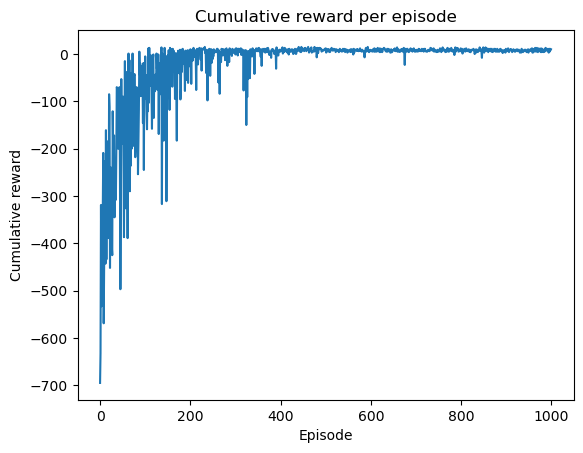

In [9]:
env = gym.make('Taxi-v3')
episodes=1000
env.reset()
rewards = []
num_centers = 495  # Number of RBF centers (can be tuned)
Agent = RBFQAgent(env, num_centers)
Train_Agent(Agent,episodes, rewards)
plt.title("Cumulative reward per episode")
plt.xlabel("Episode")
plt.ylabel("Cumulative reward")
plt.plot(rewards)
plt.show()
env.close()